In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive




---

Extrai características bastante simples. O vetor de caracterisitca tem o tamanho da imagem (h x l). Se o pixel for preto, a característica tem valor 1, caso contrário, valor 0.

In [ ]:
###############################################################################
# Dummy Pixels
###############################################################################
import os
import cv2
import pandas as pd
import progressbar

w = 20
h = 40

X = []
y = []

listOfImages = []


file = '/content/drive/My Drive/Data/digits/files.txt'
path = '/content/drive/My Drive/Data/digits'
  
arq = open(file)
lines = arq.readlines()


for line in  progressbar.progressbar(lines):
  aux = line.split('/')[1]
  image_name = aux.split(' ')[0]
  label = line.split(' ')[1]
  label = label.split('\n')
  
  f = path + '/data/' + image_name
  #print (f)
  
  ## opens the image using a single chanel (grey level)
  imagem = cv2.imread(f,0)
  
  listOfImages.append(f)
  
  ## rezise the image according to the parameters
  imagem = cv2.resize(imagem,(h,w))  #### <=====

  ## pixel count  
  v = []
  for i in range(w):
    for j in range(h):
      if(imagem[i][j] > 128):
        v.append(0)
      else:
        v.append(1)
  
  X.append(v)
  y.append(int(label[0]))
      
      
## Save data

            
# Saving the extracted features (handcrafted) in a csv file
print ('Saving data...')
df = pd.DataFrame(X)
df.to_csv('X.csv', header=False, index=False)

# Saving the classes in a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)

print ('Done!')

100% (2000 of 2000) |####################| Elapsed Time: 0:23:03 Time:  0:23:03


Saving data...
Done!



---
Extrai as características utilizando a rede pré-treinada na base ImageNet.

---



In [ ]:
###############################################################################
# HOG Features
###############################################################################
import os
import cv2
import pandas as pd
from skimage import feature
from skimage.feature import hog
import progressbar


w = 256
h = 256

X = []
y = []

listOfImages = []


file = '/content/drive/My Drive/Data/digits/files.txt'
path = '/content/drive/My Drive/Data/digits'
  
arq = open(file)
lines = arq.readlines()

for line in  progressbar.progressbar(lines):
  aux = line.split('/')[1]
  image_name = aux.split(' ')[0]
  label = line.split(' ')[1]
  label = label.split('\n')
  
  f = path + '/data/' + image_name
  #print (f)
  
  ## opens the image using a single chanel (grey level)
  imagem = cv2.imread(f,0)
  
  listOfImages.append(f)
  
  ## rezise the image according to the parameters
  imagem = cv2.resize(imagem,(h,w))  #### <=====

  hg = hog(imagem, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(8, 8), block_norm='L2-Hys')

  X.append(hg)
  y.append(int(label[0]))
      
            
# Saving the extracted features (handcrafted) in a csv file
print ('Saving data...')
df = pd.DataFrame(X)
df.to_csv('X.csv', header=False, index=False)

# Saving the classes in a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)
print ('Done!')

100% (2000 of 2000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22


Saving data...
Done!


In [ ]:
###############################################################################
# Deep features
###############################################################################
import os
import cv2
import pandas as pd

from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Input

w = 256
h = 256
file = '/content/drive/My Drive/Data/digits/files.txt'
path = '/content/drive/My Drive/Data/digits'

# Load Inception_v3 pretrained on ImageNet dataset
model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_tensor=Input(shape=(w,h,3)))


X = []  ## features
y = []  ## labels

listOfImages = []
  
arq = open(file)
lines = arq.readlines()

for line in  progressbar.progressbar(lines):
  aux = line.split('/')[1]
  image_name = aux.split(' ')[0]
  label = line.split(' ')[1]
  label = label.split('\n')
  
  f = path + '/data/' + image_name
  
  ## opens the image using a single chanel (grey level)
  imagem = cv2.imread(f)
  
  listOfImages.append(f)
  
  ## rezise the image according to the parameters
  imagem = cv2.resize(imagem,(h,w))  #### <=====

  # Extract deep features using InceptionV3 pretrained model 
  img=imagem  
  xd = image.img_to_array(img)
  xd = np.expand_dims(xd, axis=0)
  xd = preprocess_input(xd)
  deep_features = model.predict(xd)
      
  X_image_aux = []
  for aux in deep_features:
    X_image_aux = np.append(X_image_aux, np.ravel(aux))
    
  deep_features = [i for i in X_image_aux]
      
  X.append(deep_features)
  y.append(int(label[0]))
      
      
         
# Saving the extracted features into a csv file
print ('Saving data...')
df = pd.DataFrame(X)
df.to_csv('X.csv', header=False, index=False)

# Saving the classes into  a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)
print ('Done!')

In [ ]:
###############################################################################
## Classify using Holdout
###############################################################################
import pandas as pd
import numpy as np
from sklearn import  model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


# Labels
y = pd.read_csv('y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)
print(y.shape)

# Features
X = pd.read_csv('X.csv', header=None)
X=X.to_numpy()
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.5, random_state=42)

# Train the classifier
clfa = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
#clfa = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clfa = clfa.fit(X_train, y_train)

# Predict
predicted=clfa.predict(X_test)
score=clfa.score(X_test, y_test)

matrix = confusion_matrix(y_test, predicted)

# Print results
print("Accuracy = %.2f " % score)
print("Confusion Matrix:")
print(matrix)

print(classification_report(y_test, predicted, labels=[0,1, 2, 3,4,5,6,7,8,9]))

(2000,)
(2000, 800)
Accuracy = 0.92 
Confusion Matrix:
[[ 91   0   0   0   0   1   1   0   0   0]
 [  0 110   2   0   0   0   0   0   0   0]
 [  2   5  98   0   1   0   0   2   2   0]
 [  0   0   0  89   0   2   0   0   1   0]
 [  0   8   0   0  91   0   0   0   0   1]
 [  1   0   0   5   0  81   1   0   0   0]
 [  1   1   0   0   1   1  96   0   0   0]
 [  0   6   0   0   0   0   0  92   0   3]
 [  3   6   0   5   1   2   0   2  75   3]
 [  0   0   0   0   4   0   0  10   0  93]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        93
           1       0.81      0.98      0.89       112
           2       0.98      0.89      0.93       110
           3       0.90      0.97      0.93        92
           4       0.93      0.91      0.92       100
           5       0.93      0.92      0.93        88
           6       0.98      0.96      0.97       100
           7       0.87      0.91      0.89       101
           8       0.96    

(1000,)
2000
353 /content/drive/My Drive/Data/digits/data/cdf0606_11_11_0.jpg
Label: 1  | Prediction: 2


938 /content/drive/My Drive/Data/digits/data/cdf1621_46_8_1.jpg
Label: 4  | Prediction: 1


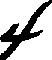

1852 /content/drive/My Drive/Data/digits/data/cdf0209_30_24_0.jpg
Label: 9  | Prediction: 4


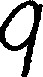

964 /content/drive/My Drive/Data/digits/data/cdf1182_38_9_1.jpg
Label: 4  | Prediction: 1


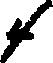

792 /content/drive/My Drive/Data/digits/data/cdf1485_22_10_5.jpg
Label: 3  | Prediction: 5


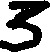

1080 /content/drive/My Drive/Data/digits/data/cdf1950_08_4_5.jpg
Label: 5  | Prediction: 0


507 /content/drive/My Drive/Data/digits/data/cdf0767_25_20_1.jpg
Label: 2  | Prediction: 8


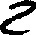

1696 /content/drive/My Drive/Data/digits/data/cdf0831_15_12_1.jpg
Label: 8  | Prediction: 7


1987 /content/drive/My Drive/Data/digits/data/cdf1492_06_13_0.jpg
Label: 9  | Prediction: 7


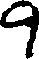

1623 /content/drive/My Drive/Data/digits/data/cdf0360_15_20_2.jpg
Label: 8  | Prediction: 3


1729 /content/drive/My Drive/Data/digits/data/cdf1791_04_7_1.jpg
Label: 8  | Prediction: 7


1833 /content/drive/My Drive/Data/digits/data/cdf1549_10_16_3.jpg
Label: 9  | Prediction: 4


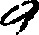

1605 /content/drive/My Drive/Data/digits/data/cdf0185_23_17_1.jpg
Label: 8  | Prediction: 1


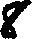

464 /content/drive/My Drive/Data/digits/data/cdf0005_26_19_1.jpg
Label: 2  | Prediction: 4


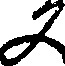

1699 /content/drive/My Drive/Data/digits/data/cdf1470_34_5_8.jpg
Label: 8  | Prediction: 3


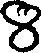

1566 /content/drive/My Drive/Data/digits/data/cdf0909_04_6_1.jpg
Label: 7  | Prediction: 1


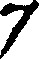

949 /content/drive/My Drive/Data/digits/data/cdf1508_14_20_2.jpg
Label: 4  | Prediction: 1


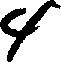

1640 /content/drive/My Drive/Data/digits/data/cdf1984_28_3_8.jpg
Label: 8  | Prediction: 3


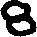

834 /content/drive/My Drive/Data/digits/data/cdf1029_30_10_5.jpg
Label: 4  | Prediction: 1


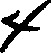

1728 /content/drive/My Drive/Data/digits/data/cdf0129_32_14_5.jpg
Label: 8  | Prediction: 3


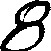

462 /content/drive/My Drive/Data/digits/data/cdf0036_39_8_0.jpg
Label: 2  | Prediction: 0


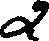

1105 /content/drive/My Drive/Data/digits/data/cdf0077_13_7_2.jpg
Label: 5  | Prediction: 3


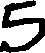

1335 /content/drive/My Drive/Data/digits/data/cdf1431_47_24_1.jpg
Label: 6  | Prediction: 0


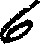

1134 /content/drive/My Drive/Data/digits/data/cdf0103_28_24_2.jpg
Label: 5  | Prediction: 3


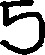

1654 /content/drive/My Drive/Data/digits/data/cdf0493_05_14_4.jpg
Label: 8  | Prediction: 1


552 /content/drive/My Drive/Data/digits/data/cdf0964_10_24_0.jpg
Label: 2  | Prediction: 1


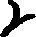

432 /content/drive/My Drive/Data/digits/data/cdf1850_16_10_5.jpg
Label: 2  | Prediction: 7


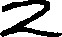

1510 /content/drive/My Drive/Data/digits/data/cdf1244_09_28_0.jpg
Label: 7  | Prediction: 1


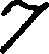

1412 /content/drive/My Drive/Data/digits/data/cdf2022_38_17_4.jpg
Label: 7  | Prediction: 1


123 /content/drive/My Drive/Data/digits/data/cdf1103_38_27_1.jpg
Label: 0  | Prediction: 6


1794 /content/drive/My Drive/Data/digits/data/cdf0794_31_11_0.jpg
Label: 8  | Prediction: 0


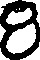

535 /content/drive/My Drive/Data/digits/data/cdf1933_13_9_2.jpg
Label: 2  | Prediction: 1


968 /content/drive/My Drive/Data/digits/data/cdf1847_26_24_2.jpg
Label: 4  | Prediction: 1


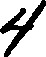

240 /content/drive/My Drive/Data/digits/data/cdf1948_41_17_4.jpg
Label: 1  | Prediction: 2


1788 /content/drive/My Drive/Data/digits/data/cdf0154_34_3_8.jpg
Label: 8  | Prediction: 9


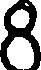

426 /content/drive/My Drive/Data/digits/data/cdf1701_10_27_1.jpg
Label: 2  | Prediction: 7


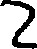

1869 /content/drive/My Drive/Data/digits/data/cdf0121_11_19_1.jpg
Label: 9  | Prediction: 7


1536 /content/drive/My Drive/Data/digits/data/cdf0882_28_22_1.jpg
Label: 7  | Prediction: 9


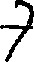

741 /content/drive/My Drive/Data/digits/data/cdf1732_28_5_3.jpg
Label: 3  | Prediction: 5


1013 /content/drive/My Drive/Data/digits/data/cdf1681_44_5_5.jpg
Label: 5  | Prediction: 3


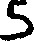

1356 /content/drive/My Drive/Data/digits/data/cdf1045_35_24_0.jpg
Label: 6  | Prediction: 4


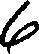

936 /content/drive/My Drive/Data/digits/data/cdf1550_34_30_0.jpg
Label: 4  | Prediction: 1


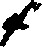

1607 /content/drive/My Drive/Data/digits/data/cdf1343_32_23_0.jpg
Label: 8  | Prediction: 3


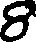

1743 /content/drive/My Drive/Data/digits/data/cdf1372_35_21_2.jpg
Label: 8  | Prediction: 1


465 /content/drive/My Drive/Data/digits/data/cdf1460_02_4_2.jpg
Label: 2  | Prediction: 1


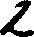

1721 /content/drive/My Drive/Data/digits/data/cdf0915_03_4_8.jpg
Label: 8  | Prediction: 1


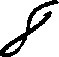

1861 /content/drive/My Drive/Data/digits/data/cdf0138_30_30_4.jpg
Label: 9  | Prediction: 7


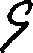

1455 /content/drive/My Drive/Data/digits/data/cdf1812_15_16_1.jpg
Label: 7  | Prediction: 1


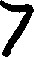

1649 /content/drive/My Drive/Data/digits/data/cdf1856_37_8_2.jpg
Label: 8  | Prediction: 1


1857 /content/drive/My Drive/Data/digits/data/cdf2032_22_20_1.jpg
Label: 9  | Prediction: 7


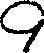

1442 /content/drive/My Drive/Data/digits/data/cdf0882_28_9_3.jpg
Label: 7  | Prediction: 1


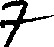

598 /content/drive/My Drive/Data/digits/data/cdf0971_24_19_0.jpg
Label: 2  | Prediction: 8


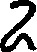

1637 /content/drive/My Drive/Data/digits/data/cdf1629_49_23_1.jpg
Label: 8  | Prediction: 9


1040 /content/drive/My Drive/Data/digits/data/cdf0343_35_4_5.jpg
Label: 5  | Prediction: 6


1679 /content/drive/My Drive/Data/digits/data/cdf0677_30_29_3.jpg
Label: 8  | Prediction: 9


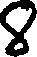

1320 /content/drive/My Drive/Data/digits/data/cdf1664_04_8_1.jpg
Label: 6  | Prediction: 5


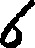

1812 /content/drive/My Drive/Data/digits/data/cdf1749_23_17_3.jpg
Label: 9  | Prediction: 7


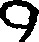

1121 /content/drive/My Drive/Data/digits/data/cdf0264_18_25_1.jpg
Label: 5  | Prediction: 3


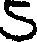

513 /content/drive/My Drive/Data/digits/data/cdf1363_19_29_2.jpg
Label: 2  | Prediction: 1


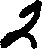

1688 /content/drive/My Drive/Data/digits/data/cdf1481_35_11_2.jpg
Label: 8  | Prediction: 4


1677 /content/drive/My Drive/Data/digits/data/cdf1863_44_25_2.jpg
Label: 8  | Prediction: 0


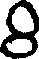

1985 /content/drive/My Drive/Data/digits/data/cdf1444_03_10_2.jpg
Label: 9  | Prediction: 4


1628 /content/drive/My Drive/Data/digits/data/cdf0685_40_12_2.jpg
Label: 8  | Prediction: 1


1538 /content/drive/My Drive/Data/digits/data/cdf1719_12_8_0.jpg
Label: 7  | Prediction: 9


1828 /content/drive/My Drive/Data/digits/data/cdf1609_27_26_4.jpg
Label: 9  | Prediction: 7


560 /content/drive/My Drive/Data/digits/data/cdf0952_49_30_0.jpg
Label: 2  | Prediction: 1


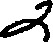

1630 /content/drive/My Drive/Data/digits/data/cdf1128_24_30_0.jpg
Label: 8  | Prediction: 5


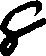

812 /content/drive/My Drive/Data/digits/data/cdf0496_09_10_5.jpg
Label: 4  | Prediction: 1


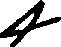

1974 /content/drive/My Drive/Data/digits/data/cdf0144_05_18_1.jpg
Label: 9  | Prediction: 7


1815 /content/drive/My Drive/Data/digits/data/cdf1826_01_5_9.jpg
Label: 9  | Prediction: 7


1175 /content/drive/My Drive/Data/digits/data/cdf2071_28_24_2.jpg
Label: 5  | Prediction: 3


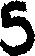

865 /content/drive/My Drive/Data/digits/data/cdf1966_31_18_4.jpg
Label: 4  | Prediction: 1


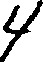

410 /content/drive/My Drive/Data/digits/data/cdf0875_02_5_2.jpg
Label: 2  | Prediction: 0


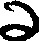

668 /content/drive/My Drive/Data/digits/data/cdf1081_19_16_2.jpg
Label: 3  | Prediction: 8


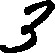

1871 /content/drive/My Drive/Data/digits/data/cdf1663_13_25_0.jpg
Label: 9  | Prediction: 7


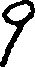

1477 /content/drive/My Drive/Data/digits/data/cdf1378_08_17_2.jpg
Label: 7  | Prediction: 9


1338 /content/drive/My Drive/Data/digits/data/cdf1346_08_30_4.jpg
Label: 6  | Prediction: 1


1591 /content/drive/My Drive/Data/digits/data/cdf0946_31_29_1.jpg
Label: 7  | Prediction: 1


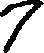

136 /content/drive/My Drive/Data/digits/data/cdf0138_30_30_3.jpg
Label: 0  | Prediction: 5


1760 /content/drive/My Drive/Data/digits/data/cdf0536_45_17_2.jpg
Label: 8  | Prediction: 0


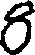

1799 /content/drive/My Drive/Data/digits/data/cdf0990_06_29_2.jpg
Label: 8  | Prediction: 5


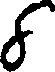

893 /content/drive/My Drive/Data/digits/data/cdf2045_15_18_5.jpg
Label: 4  | Prediction: 9


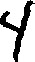

1805 /content/drive/My Drive/Data/digits/data/cdf1260_34_14_1.jpg
Label: 9  | Prediction: 4


1858 /content/drive/My Drive/Data/digits/data/cdf1951_19_14_4.jpg
Label: 9  | Prediction: 7


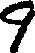

In [ ]:
###############################################################################
# Show confusions
###############################################################################

from google.colab.patches import cv2_imshow

print(predicted.shape)
print (len(X))
for i in range(len(predicted)):

  ## Erro...
  if (predicted[i] != y_test[i]):
      
    ### procurar o vetor 
    for j in range(len(X)):
      dist = np.linalg.norm(X[j]-X_test[i]) 
      if (dist == 0.0):
        break
      
    print (j,listOfImages[j])  
    print("Label:", y[j], " | Prediction:", predicted[i] )
    im=cv2.imread(listOfImages[j])
    cv2_imshow(im)

